In [153]:
import matplotlib.pyplot as plt
import numpy as np
import mpltex
from scipy.optimize import minimize_scalar
import pint
import mwbr
ureg = pint.UnitRegistry()

In [15]:
def load_csv(filename):
    data = np.genfromtxt(filename, delimiter='\t')
    return data

In [20]:
q_data = []
for begin_val, end_val in zip([0, 25, 50, 75, 100, 125], [30, 55, 80, 105, 130, 155]):
    q_data.append(load_csv(f'./window_{begin_val}_{end_val}/qs_f_14.dat'))


In [21]:
# connect the last five with the first five between consecutive windows

offsets = []
for i in range(len(q_data)-1):
    q_left = q_data[i]
    q_right = q_data[i+1]

    mean_left = np.mean(q_left[-5:,1])
    mean_right = np.mean(q_right[:5,1])
    print(mean_left, mean_right)

    offsets.append(mean_right - mean_left + (offsets[-1] if offsets else 0))



3732.2339999999995 3460.5199999999995
3735.0620000000004 3536.1040000000003
3818.0379999999996 3600.232
3890.318 4885.317999999999
5181.802 7412.197999999999


In [99]:
# define a function for the l2 norm of the difference between the last five of one array
# and the first five of the next array
def l2_norm(q_left, q_right):
    return np.linalg.norm(q_left[-6:,1] - q_right[:6,1])

# function which optimizes the offset of array 2 to array 1 such that the l2 norm is minimized
def optimize_offset(q_left, q_right):
    # define a function which returns the l2 norm for a given offset
    def f(offset):
        return l2_norm(q_left, q_right + offset)

    # find the minimum of the function
    res = minimize_scalar(f)
    return res.x

offsets = []
concatenate_n = q_data[0][:,0]
concatenate_q = q_data[0][:,1]
for i in range(len(q_data)-1):
    q_left = q_data[i]
    q_right = q_data[i+1]

    # determine the offset which minimizes the l2 norm
    offset = optimize_offset(q_left, q_right)
    print(offset)
    total_offset = offset + (offsets[-1] if offsets else 0)
    offsets.append(total_offset)

    concatenate_n = np.concatenate([concatenate_n, q_right[5:,0]])
    concatenate_q = np.concatenate([concatenate_q, q_right[5:,1]+total_offset])
    # mean_profile = np.mean([q_left[-6:, 1], q_right[:6, 1]+total_offset], axis=0)

    # concatenate_q = np.concatenate([concatenate_q, mean_profile, q_right[5:,1]+total_offset])
    # concatenate_n = np.concatenate([concatenate_n, q_left[-6:,0], q_right[5:,0]])


261.2649987031455
188.25166635412103
206.7783333127661
-1006.2866683363959
-2241.734983696791


In [182]:
alex_qs = np.loadtxt('./AlexQs.dat')

array([[0.00000000e+00, 3.44673358e+03],
       [1.00000000e+00, 3.45933306e+03],
       [2.00000000e+00, 3.47126995e+03],
       [3.00000000e+00, 3.48285522e+03],
       [4.00000000e+00, 3.49420266e+03],
       [5.00000000e+00, 3.50536660e+03],
       [6.00000000e+00, 3.51640295e+03],
       [7.00000000e+00, 3.52731411e+03],
       [8.00000000e+00, 3.53814224e+03],
       [9.00000000e+00, 3.54889407e+03],
       [1.00000000e+01, 3.55957840e+03],
       [1.10000000e+01, 3.57021618e+03],
       [1.20000000e+01, 3.58082745e+03],
       [1.30000000e+01, 3.59138491e+03],
       [1.40000000e+01, 3.60190551e+03],
       [1.50000000e+01, 3.61241336e+03],
       [1.60000000e+01, 3.62288714e+03],
       [1.70000000e+01, 3.63334643e+03],
       [1.80000000e+01, 3.64378848e+03],
       [1.90000000e+01, 3.65423016e+03],
       [2.00000000e+01, 3.66463604e+03],
       [2.10000000e+01, 3.67506323e+03],
       [2.20000000e+01, 3.68547625e+03],
       [2.30000000e+01, 3.69587445e+03],
       [2.400000

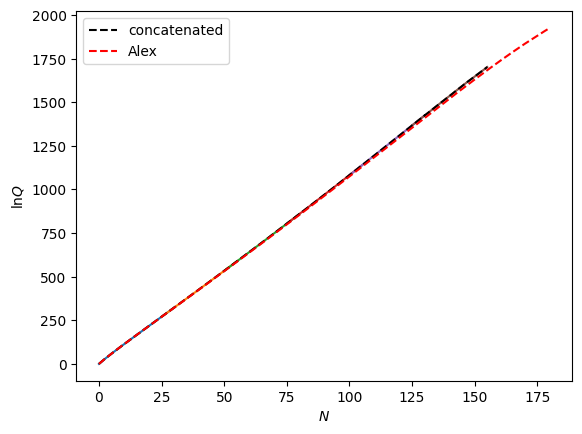

In [186]:
fig, ax = plt.subplots()
zero = q_data[0][0,1]

plt.plot(q_data[0][:,0], -zero+q_data[0][:,1])
offsets_p = offsets.copy()
for window in q_data[1:]:
    plt.plot(window[:,0], -zero+window[:,1]+offsets_p.pop(0))

# plt.xlabel('$N$')
# plt.ylabel('$\ln Q$')
plt.plot(concatenate_n, -zero+concatenate_q, '--', color='black', label='concatenated')
plt.plot(alex_qs[:,0], alex_qs[:,1]-alex_qs[0,1], '--', color='red', label='Alex')

plt.legend()
plt.xlabel('$N$')
plt.ylabel('$\ln Q$')

plt.show()

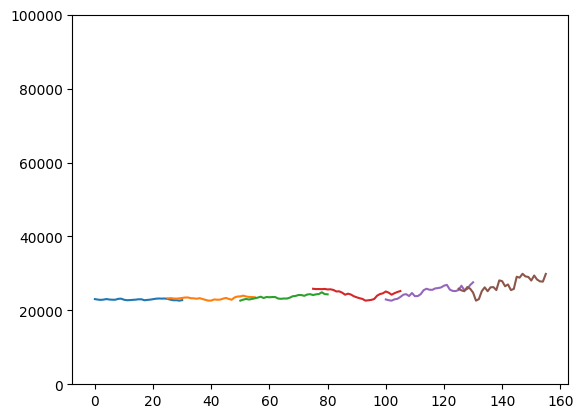

In [77]:
fig, ax = plt.subplots()
zero = q_data[0][0,1]

plt.plot(q_data[0][:,0], q_data[0][:,2])
for window in q_data[1:]:
    plt.plot(window[:,0], +window[:,2])

# plt.xlabel('$N$')
# plt.ylabel('$\ln Q$')
plt.ylim((0, 1e5))
plt.show()

## Grand Potential

In [204]:
N = concatenate_n
lnq = concatenate_q
epsilon = 0.1892*ureg.kcal/ureg.mol
sigma = 3.75*ureg.angstrom
mass = 28.0*ureg.atomic_mass_constant
T = 95.21 * ureg.kelvin
ureg.define(f'epsilon = {epsilon}')
ureg.define(f'sigma = {sigma}')
ureg.define(f'mass = {mass}')

#fugacity = 1.5e10*ureg.bar
fugacity = 5.9*ureg.bar

db = ureg.planck_constant / np.sqrt(2*np.pi * mass * ureg.boltzmann_constant * T)
mu = ureg.boltzmann_constant*T * np.log((fugacity)*db**3/(ureg.boltzmann_constant*T))

omega = -1*ureg.boltzmann_constant*T*(lnq-lnq[0]) - mu*N
mu/ureg.boltzmann_constant

-1043.6786261466127 <Unit('kelvin')>

/home/pstaerk/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


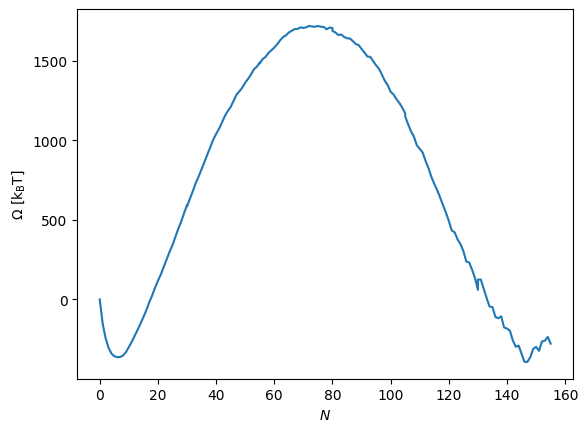

In [205]:
plt.plot(N, omega)
plt.xlabel('$N$')
plt.ylabel('$\Omega$ [k$_{\mathrm{B}}$T]')
plt.show()

## Check with PyMWBR

Alex EOS for LJ fluids:

In [164]:
epsilon_lj = epsilon.to('boltzmann_constant * kelvin/ molecule').magnitude
sigma_lj = sigma.to('nanometer').magnitude
mass_lj = mass.magnitude

In [168]:
eos = mwbr.MBWR(rcut=4., sigma=sigma_lj, epsilon=epsilon_lj, mass=mass_lj)

eos.fsat(T)


/home/pstaerk/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2360: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  args = [asarray(arg) for arg in args]
/home/pstaerk/Documents/Uni/PhD/binaries/lammps_develop/examples/mc/n2/mwbr.py:201: RuntimeWarning: divide by zero encountered in divide
  return self.Ar(rho,T) + P/rho + T*np.log(rho*self.deBroglie(T)**3)
/home/pstaerk/Documents/Uni/PhD/binaries/lammps_develop/examples/mc/n2/mwbr.py:201: RuntimeWarning: divide by zero encountered in log
  return self.Ar(rho,T) + P/rho + T*np.log(rho*self.deBroglie(T)**3)
/home/pstaerk/Documents/Uni/PhD/binaries/lammps_develop/examples/mc/n2/mwbr.py:201: RuntimeWarning: invalid value encountered in add
  return self.Ar(rho,T) + P/rho + T*np.log(rho*self.deBroglie(T)**3)


RuntimeError: Tolerance of 0.0030871437694059978 reached. Failed to converge after 1 iterations, value is 29.874524837844394.